In [1]:
import pandas as pd
import numpy as np
import pandas as pd 
import re
import os
from datetime import datetime
from collections import Counter
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud ,STOPWORDS, ImageColorGenerator
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import word2vec
import plotly.tools as tls
import plotly.plotly as py
from plotly.offline import init_notebook_mode
import plotly.graph_objs as go
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()
sns.set()

In [2]:
p = "YlGnBu"
p2 = "YlGn"
p3 = "Greys"

In [3]:
df = pd.read_csv("../input/nyc-jobs.csv")

In [4]:
df.head()

,Job ID,Agency,Posting Type,# Of Positions,Business Title,Civil Service Title,Title Code No,Level,Job Category,Full-Time/Part-Time indicator,Salary Range From,Salary Range To,Salary Frequency,Work Location,Division/Work Unit,Job Description,Minimum Qual Requirements,Preferred Skills,Additional Information,To Apply,Hours/Shift,Work Location 1,Recruitment Contact,Residency Requirement,Posting Date,Post Until,Posting Updated,Process Date
0,87990,DEPARTMENT OF BUSINESS SERV.,Internal,1,Account Manager,CONTRACT REVIEWER (OFFICE OF L,40563,1,NaN,NaN,42405.00,65485.00,Annual,110 William St. N Y,Strategy & Analytics,Division of Economic & Financial Opportunity (...,1.\tA baccalaureate degree from an accredited ...,â€¢\tExcellent interpersonal and organizationa...,"Salary range for this position is: $42,405 - $...",NaN,NaN,NaN,NaN,New York City residency is generally required ...,2011-06-24T00:00:00.000,NaN,2011-06-24T00:00:00.000,2019-12-17T00:00:00.000
1,97899,DEPARTMENT OF BUSINESS SERV.,Internal,1,"EXECUTIVE DIRECTOR, BUSINESS DEVELOPMENT",ADMINISTRATIVE BUSINESS PROMOT,10009,M3,NaN,F,60740.00,162014.00,Annual,110 William St. N Y,Tech Talent Pipeline,The New York City Department of Small Business...,1. A baccalaureate degree from an accredited c...,NaN,NaN,"In addition to applying through this website, ...",NaN,NaN,NaN,New York City residency is generally required ...,2012-01-26T00:00:00.000,NaN,2012-01-26T00:00:00.000,2019-12-17T00:00:00.000
2,132292,NYC HOUSING AUTHORITY,External,52,Maintenance Worker - Technical Services-Heatin...,MAINTENANCE WORKER,90698,0,Maintenance & Operations,F,51907.68,54580.32,Annual,Heating Mgt-Operations,Management Services Department,"Under direct supervision, assist in the routin...",1. Three years of full-time satisfactory exper...,1. A High School Diploma or GED. 2. CDL Dri...,1. A Motor Vehicle Driverâ€™s License valid i...,"Click the ""Apply Now"" button.",NaN,NaN,NaN,NYCHA has no residency requirements.,2013-10-24T00:00:00.000,NaN,2013-12-12T00:00:00.000,2019-12-17T00:00:00.000
3,132292,NYC HOUSING AUTHORITY,Internal,52,Maintenance Worker - Technical Services-Heatin...,MAINTENANCE WORKER,90698,0,Maintenance & Operations,F,51907.68,54580.32,Annual,Heating Mgt-Operations,Management Services Department,"Under direct supervision, assist in the routin...",1. Three years of full-time satisfactory exper...,1. A High School Diploma or GED. 2. CDL Dri...,1. A Motor Vehicle Driverâ€™s License valid i...,"Click the ""Apply Now"" button.",NaN,NaN,NaN,NYCHA has no residency requirements.,2013-10-24T00:00:00.000,NaN,2013-12-12T00:00:00.000,2019-12-17T00:00:00.000
4,133921,NYC HOUSING AUTHORITY,Internal,50,Temporary Painter,PAINTER,91830,0,Maintenance & Operations,F,35.00,35.00,Hourly,DMP-Contract & Analysis Unit,Dept of Management & Planning,Responsibilities of selected candidates will i...,1. Five years of full-time satisfactory experi...,NaN,SPECIAL NOTE: 1. This is a temporary assig...,"Click the ""Apply Now"" button.",NaN,NaN,NaN,NYCHA has no residency requirement.,2014-01-09T00:00:00.000,NaN,2014-01-08T00:00:00.000,2019-12-17T00:00:00.000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2946 entries, 0 to 2945
Data columns (total 28 columns):
Job ID                           2946 non-null int64
Agency                           2946 non-null object
Posting Type                     2946 non-null object
# Of Positions                   2946 non-null int64
Business Title                   2946 non-null object
Civil Service Title              2946 non-null object
Title Code No                    2946 non-null object
Level                            2946 non-null object
Job Category                     2944 non-null object
Full-Time/Part-Time indicator    2751 non-null object
Salary Range From                2946 non-null float64
Salary Range To                  2946 non-null float64
Salary Frequency                 2946 non-null object
Work Location                    2946 non-null object
Division/Work Unit               2946 non-null object
Job Description                  2946 non-null object
Minimum Qual Requirements    

## Data cleaning & Feature engineering

In [6]:
# helper functions
def plot_wordcloud(text):
    wordcloud = WordCloud(background_color='white',
                     width=1024, height=720).generate(text)
    plt.clf()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

def parse_categories(x):
    l = x.replace('&', ',').split(',')
    l = [x.strip().rstrip(',') for x in l]
    key_categories.extend(l)

def parse_keywords(x, l):
    x = x.lower()
    tokens = nltk.word_tokenize(x)
    stop_words = set(stopwords.words('english'))
    token_l = [w for w in tokens if not w in stop_words and w.isalpha()]
    l.extend(token_l)
    
def preferred_skills(x):
    kwl = []
    df[df.job_category==x].preferred_skills.dropna().apply(parse_keywords, l=kwl)
    kwl = pd.Series(kwl)
    return kwl.value_counts()[:20]


In [7]:
df.drop(['Recruitment Contact', 'Post Until'], axis=1, inplace=True)
df.columns = ['id', 'agency', 'posting_type', 'number_of_positions', 'business_title', 'civil_service_title', 'title_code_number', 'level', 'job_category', 'full-time/part-time', 'salary_range_low', 'salary_range_high', 'salary_frequency', 'work_location', 'work_unit', 'job_description', 'minimum_requirements', 'preferred_skills', 'additional_info', 'to_apply', 'shift', 'work_location_1', 'residency_requirement', 'posting_date', 'posting_updated', 'process_date' ]

In [8]:
df.job_category.value_counts()

Engineering, Architecture, & Planning                                                                                                            504
Technology, Data & Innovation                                                                                                                    313
Legal Affairs                                                                                                                                    226
Public Safety, Inspections, & Enforcement                                                                                                        182
Building Operations & Maintenance                                                                                                                181
Finance, Accounting, & Procurement                                                                                                               169
Administration & Human Resources                                                                          

> - There are many jobs demanding composite skillsets, lets break the composite categories down to single categories and generate a  countplot

In [9]:
key_categories = []
df.job_category.dropna().apply(parse_categories)
key_categories = pd.Series(key_categories)
key_categories = key_categories[key_categories!='']
popular_categories = key_categories.value_counts().iloc[:25]

## Full time or Part time?

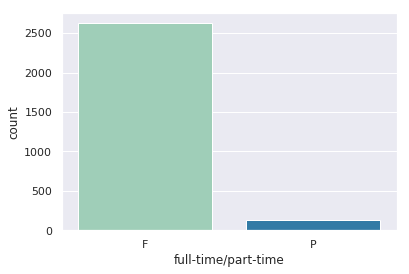

In [10]:
sns.countplot(x='full-time/part-time', data=df, palette=p)

## Salary frequency

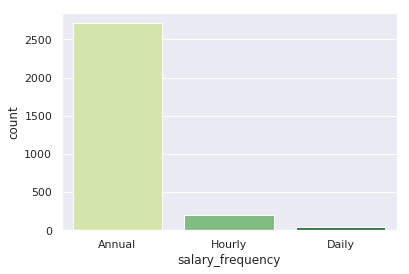

In [11]:
sns.countplot(x='salary_frequency', data=df, palette=p2)

## Most in-demand job categories

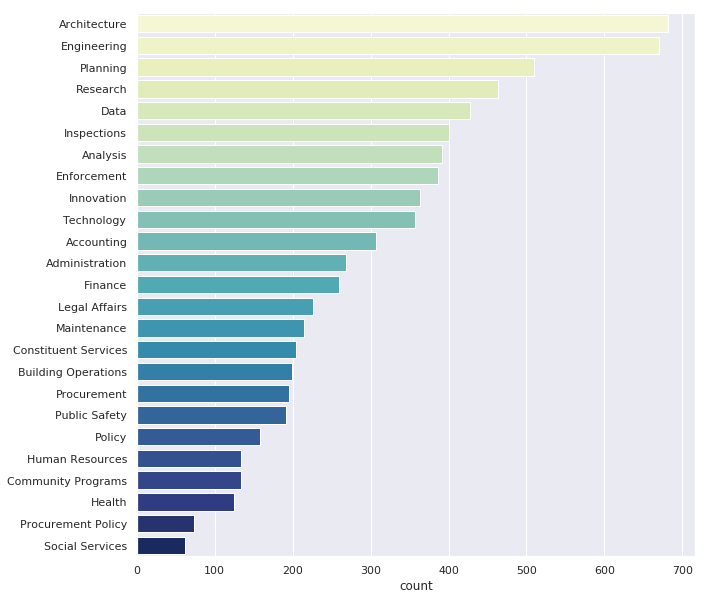

In [12]:
plt.figure(figsize=(10,10))
sns.countplot(y=key_categories, order=popular_categories.index, palette=p)

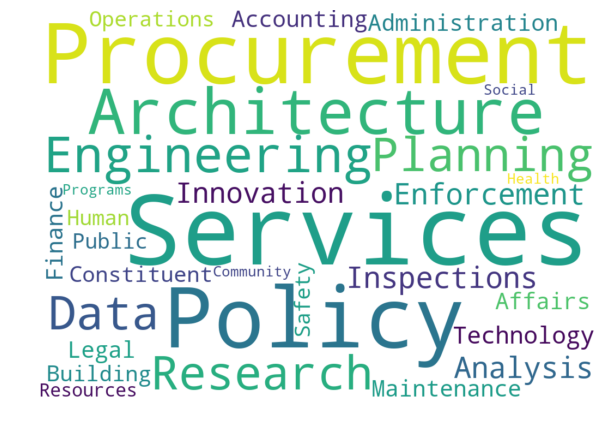

In [13]:
plt.figure(figsize=(10,8))
plot_wordcloud(' '.join(popular_categories.index.tolist()))

## Most popular job titles

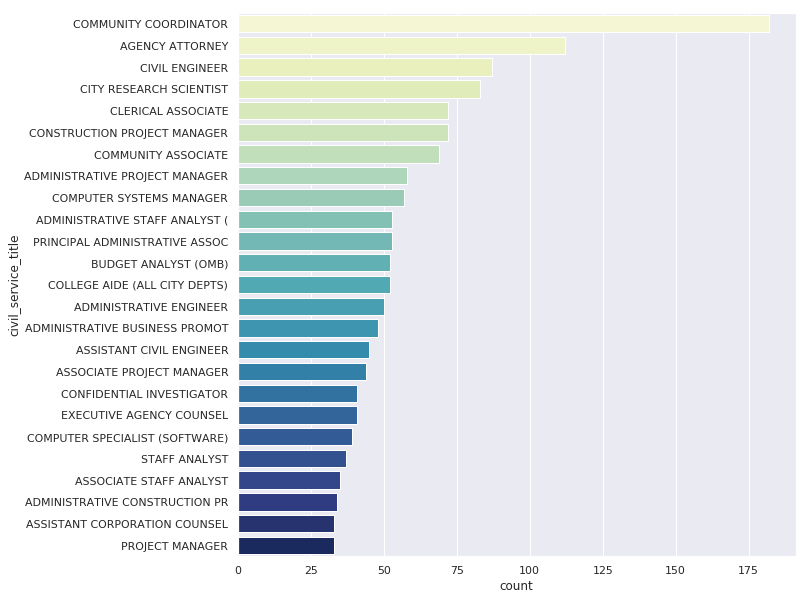

In [14]:
plt.figure(figsize=(10,10))
titles_freq = df.civil_service_title.value_counts()
popular_titles = titles_freq.iloc[:25]
sns.countplot(y="civil_service_title", data=df, order=popular_titles.index, palette=p)

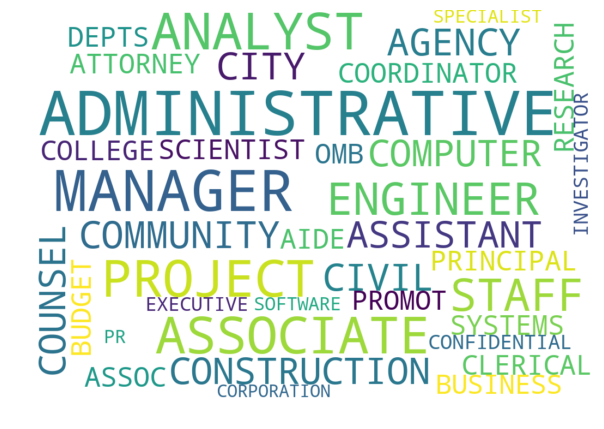

In [15]:
plt.figure(figsize=(10,8))
plot_wordcloud(' '.join(popular_titles.index.tolist()))

## Least popular job titles

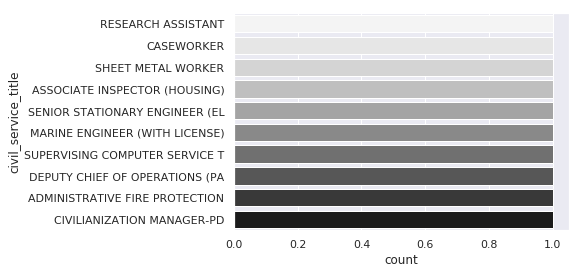

In [16]:
least_popular = titles_freq.iloc[-10:]
sns.countplot(y="civil_service_title", data=df, order=least_popular.index, palette=p3)

## Jobs with highest low salary range (annual)

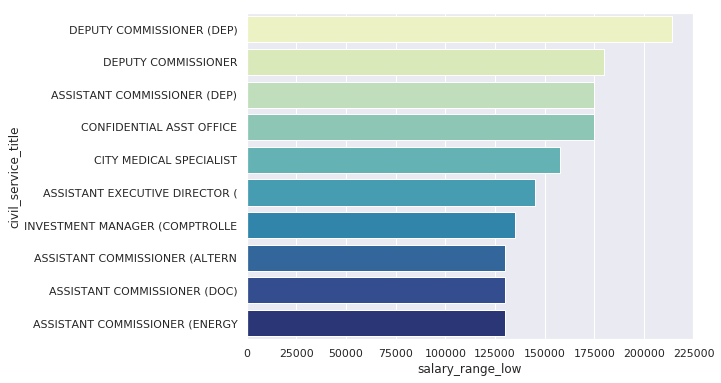

In [17]:
salary_table = df[['civil_service_title', 'salary_range_low', 'salary_range_high']]
jobs_highest_low_range = pd.DataFrame(salary_table.groupby(['civil_service_title'])['salary_range_low'].mean().nlargest(10)).reset_index()
plt.figure(figsize=(8,6))
sns.barplot(y='civil_service_title', x='salary_range_low', data=jobs_highest_low_range, palette=p)

## Jobs with highest high salary range (annual)

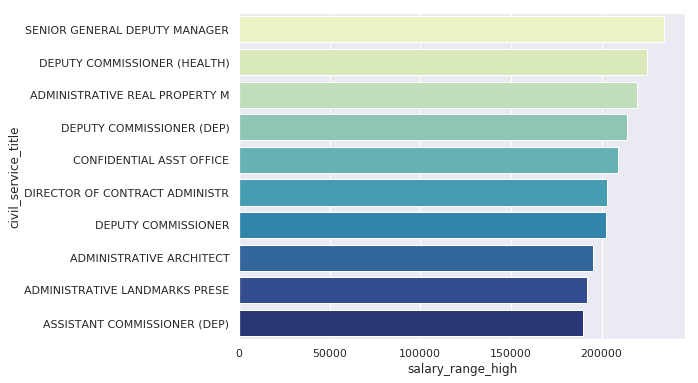

In [18]:
jobs_highest_high_range = pd.DataFrame(salary_table.groupby(['civil_service_title'])['salary_range_high'].mean().nlargest(10)).reset_index()
plt.figure(figsize=(8,6))
sns.barplot(y='civil_service_title', x='salary_range_high', data=jobs_highest_high_range, palette=p)

## Highest paying jobs on an hourly basis

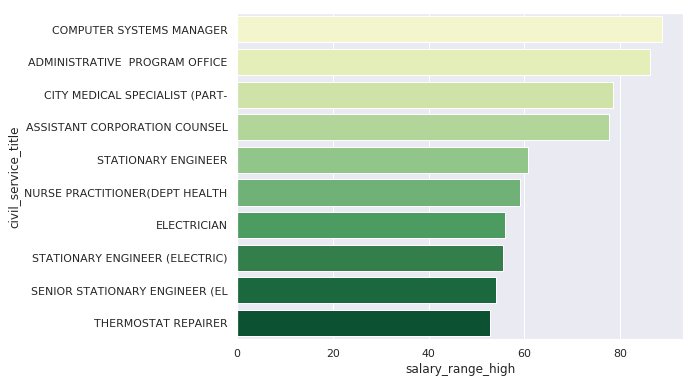

In [19]:
hourly_jobs = df[df.salary_frequency == 'Hourly']
jobs_highest_high_range_hourly = pd.DataFrame(hourly_jobs.groupby(['civil_service_title'])['salary_range_high'].mean().nlargest(10)).reset_index()
plt.figure(figsize=(8,6))
sns.barplot(y='civil_service_title', x='salary_range_high', data=jobs_highest_high_range_hourly, palette=p2)

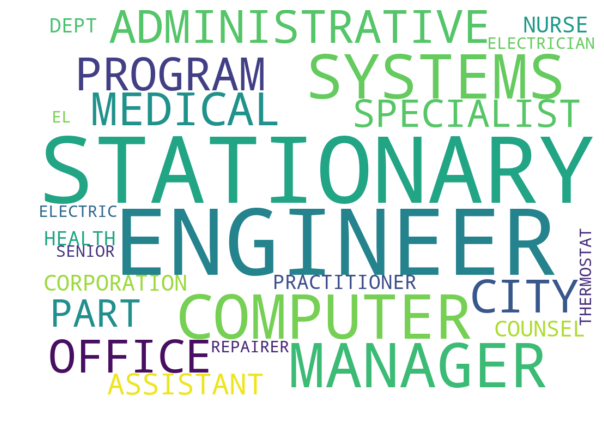

In [20]:
plt.figure(figsize=(10,8))
plot_wordcloud(' '.join(jobs_highest_high_range_hourly['civil_service_title'].tolist()))

## Hourly jobs salary distribution

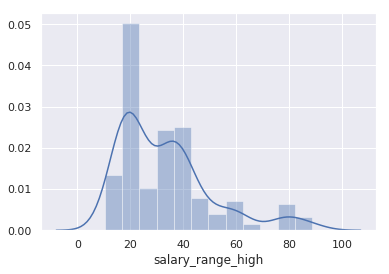

In [21]:
sns.distplot(hourly_jobs.salary_range_high)

## Popular work units

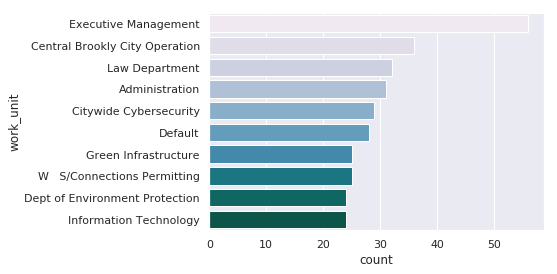

In [22]:
popular_divisions = df.work_unit.value_counts().iloc[:10]
sns.countplot(y='work_unit', data=df, order=popular_divisions.index, palette='PuBuGn')

## Most common keywords in job descriptions

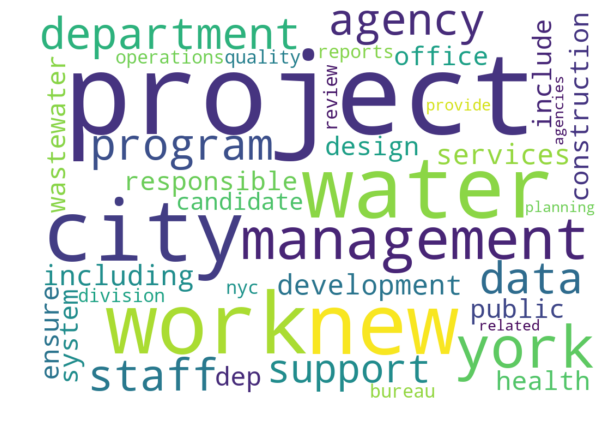

In [23]:
job_description_keywords = []
df.job_description.apply(parse_keywords, l=job_description_keywords)
plt.figure(figsize=(10, 8))
counter = Counter(job_description_keywords)
common = [x[0] for x in counter.most_common(40)]
plot_wordcloud(' '.join(common))

## Most popular preferred skills per job category

In [24]:
popular_categories = df.job_category.value_counts()[:5]
popular_categories

Engineering, Architecture, & Planning        504
Technology, Data & Innovation                313
Legal Affairs                                226
Public Safety, Inspections, & Enforcement    182
Building Operations & Maintenance            181
Name: job_category, dtype: int64

In [25]:
preferred_skills(popular_categories.index[0]).iplot(title='engineering', kind='bar', color='khaki')

In [26]:
preferred_skills(popular_categories.index[1]).iplot(title='technology', kind='bar', color='deepskyblue')

In [27]:
preferred_skills(popular_categories.index[2]).iplot(title='public safety', kind='bar', color='green')

In [28]:
preferred_skills(popular_categories.index[3]).iplot(title='health', kind='bar', color='powderblue')

In [29]:
preferred_skills(popular_categories.index[4]).iplot(title='legal affairs', kind='bar', color='darkolivegreen')

## Minimum Qualification Wordcloud

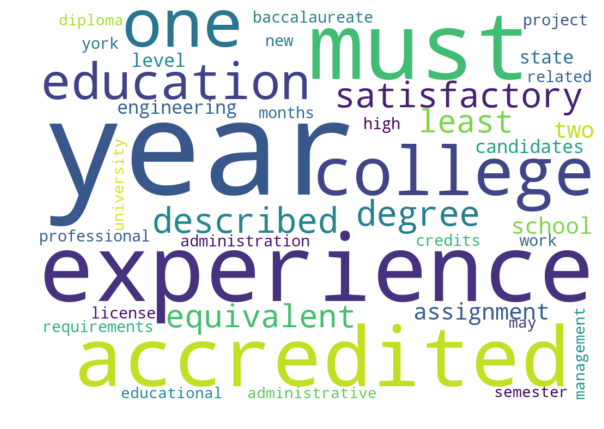

In [30]:
qualification_keywords = []
df.minimum_requirements.dropna().apply(parse_keywords, l=qualification_keywords)
plt.figure(figsize=(10, 8))
counter = Counter(qualification_keywords)
common = [x[0] for x in counter.most_common(40)]
plot_wordcloud(' '.join(common))